# Week 3
For this week's analysis I decided to move my focus to trying to figure out what country the SARS-Cov-2 may have traveled to the USA from. Using my work from last week, I decided to continue using the data provided by https://covid19.galaxyproject.org/genomics/4-Variation/current_complete_ncov_genomes.fasta. I also am using the same multiple sequence alignment and position table as I did for my analysis last week.

However, in order to perform my analysis this week, I needed a litle more information for my data set, such as the country of origin and date of collection for each sequence in the data set. This data was provided by https://www.ncbi.nlm.nih.gov/core/assets/genbank/files/ncov-sequences.yaml. In addition to the information I was looking for, the file also contains the accesion of the sequence, accesion listing, and the state it was collected in, if that information is available. 

In [83]:
import wget

url = 'https://www.ncbi.nlm.nih.gov/core/assets/genbank/files/ncov-sequences.yaml'
filename = 'ncov-sequences.yaml'
wget.download(url, filename)

'ncov-sequences (2).yaml'

In [85]:
import yaml

#Read in the information for the sequences
file = open(filename)
info = yaml.load(file, Loader=yaml.FullLoader)
file.close()

## Pulling the data out of the yaml file
Once I had read in the sequence information, I needed to next pull out what I needed and store it in a dicitonary. Using the accession of sequence as the key, I stored the country of origin and collection date of the sequence together for use later.

In [114]:
#Pull out the country and date information for each sequence
countries_and_dates = {}
for data in info['genbank-sequences']:
    country = data['country']
    #We want just the country, not the state
    if country is not None:
        country = country.split(':')[0]
    date = data['collection_date']
    countries_and_dates[data['accession']] = (country, date)

## Modifying the position table
Since I was using the same position table I used for my previous analysis, I needed to read in the position table I had saved.

In [127]:
import pandas as pd
import numpy as np

#read in the position table
position_table = pd.read_csv('../../data/position_table.csv')

Once I had read in the position table, I needed to add in the information I had extracted from the yaml file for each of the sequences. I also decided to add an additional name column that matched the accession for each sequence so I would not constanly neeed to remove the '.1' from the end of the seqid of the sequence in order to reference the information in the future.

In [128]:
#Add the country and date information to the position table for each sequence
for i in range(len(position_table)):
    #Add the name of the sequence without the '.1' ending
    name = position_table.loc[i, 'seqid'][:-2]
    position_table.loc[i, 'name'] = name
    if name in countries_and_dates:
        country, date = countries_and_dates[position_table.loc[i, 'name']]
        position_table.loc[i, 'country'] = country
        position_table.loc[i, 'date'] = date
    else:
        position_table.loc[i, 'country'] = None
        position_table.loc[i, 'date'] = None

In [129]:
position_table

,seqid,S_1_1,S_1_2,S_1_3,S_2_1,S_2_2,S_2_3,S_3_1,S_3_2,S_3_3,...,S_1271_3,S_1272_1,S_1272_2,S_1272_3,S_1273_1,S_1273_2,S_1273_3,name,country,date
0,MT007544.1,A,T,G,T,T,T,G,T,T,...,T,T,A,C,A,C,A,MT007544,Australia,2020-01-25
1,MT019529.1,A,T,G,T,T,T,G,T,T,...,T,T,A,C,A,C,A,MT019529,China,2019-12-23
2,MT019530.1,A,T,G,T,T,T,G,T,T,...,T,T,A,C,A,C,A,MT019530,China,2019-12-30
3,MT019531.1,A,T,G,T,T,T,G,T,T,...,T,T,A,C,A,C,A,MT019531,China,2019-12-30
4,MT019532.1,A,T,G,T,T,T,G,T,T,...,T,T,A,C,A,C,A,MT019532,China,2019-12-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672,MT334544.1,A,T,G,T,T,T,G,T,T,...,T,T,A,C,A,C,A,MT334544,USA,2020-03-19
673,MT334546.1,A,T,G,T,T,T,G,T,T,...,T,T,A,C,A,C,A,MT334546,USA,2020-03-19
674,MT334547.1,A,T,G,T,T,T,G,T,T,...,T,T,A,C,A,C,A,MT334547,USA,2020-03-19
675,MT334557.1,A,T,G,T,T,T,G,T,T,...,T,T,A,C,A,C,A,MT334557,USA,2020-03-20


In order to clean up any missing data, I removed any entry from the position table that did not have a date and/or a country.

In [130]:
#Remove any entry without a date or country
position_table = position_table[~position_table['date'].isna()]
position_table = position_table[~position_table['country'].isna()]
position_table['date'] = pd.to_datetime(position_table['date'])

In order begin finding the data to use in my analysis from the partition table, I selected the sequence from the position table with the earliest collection date in the USA as a starting point. With this sequence selected, I then wanted to find all other seuquences that had a collection date of before or on the collection date of the selected USA sequence.

In [131]:
#Find the eqrliest USA genome sequence
us_genome = sorted(position_table[position_table['country'] == 'USA']['date'])[0]
us_genome

Timestamp('2020-01-01 00:00:00')

In [132]:
genome_table = position_table.set_index("seqid")
subset_seqs = genome_table[genome_table["date"] <= us_genome].index

In order to use these sequences to create a tree, I decided to create a distance matrix in order to construct a distance based phylogenetic tree.

In [134]:
#Construct the distance matrix
distances = {}
for i,seqid1 in enumerate(subset_seqs):
    distances[seqid1,seqid1]=0
    for j in range(i+1,len(subset_seqs)):
        seqid2 = subset_seqs[j]
        distances[seqid1,seqid2] = sum(genome_table.loc[seqid1] != genome_table.loc[seqid2])
        distances[seqid2,seqid1] = distances[seqid1,seqid2]
distances = pd.Series(distances).unstack()

distances

,MT019529.1,MT019530.1,MT019531.1,MT019532.1,MT019533.1,MT039890.1,MT291826.1,MT291827.1,MT291828.1,MT291829.1,MT291830.1,MT326173.1
MT019529.1,0,2,2,2,2,4,2,2,3,2,2,5
MT019530.1,2,0,1,1,2,4,1,1,2,1,1,5
MT019531.1,2,1,0,1,2,4,1,1,2,1,1,5
MT019532.1,2,1,1,0,2,4,1,1,2,1,1,5
MT019533.1,2,2,2,2,0,3,2,2,3,2,2,4
MT039890.1,4,4,4,4,3,0,4,4,5,4,4,5
MT291826.1,2,1,1,1,2,4,0,1,2,1,1,5
MT291827.1,2,1,1,1,2,4,1,0,2,1,1,5
MT291828.1,3,2,2,2,3,5,2,2,0,2,2,6
MT291829.1,2,1,1,1,2,4,1,1,2,0,1,5


## Tree Construction
Same as how I created my trees in week 2, I again utilized biopython for constructing my phylogenetic trees.

In [135]:
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo

#Convert to biopython distance matrix
matrix = np.tril(distances.values).tolist()
for i in range(len(matrix)):
    matrix[i] = matrix[i][:i+1]
dm = DistanceMatrix(list(distances.index), matrix)

### Neighbor Joining Tree
The first tree I wanted to make was a distacne tree using the Neighbor Joining algorithm. Using biopython's DistanceTreeConstructor class, I was able to do so

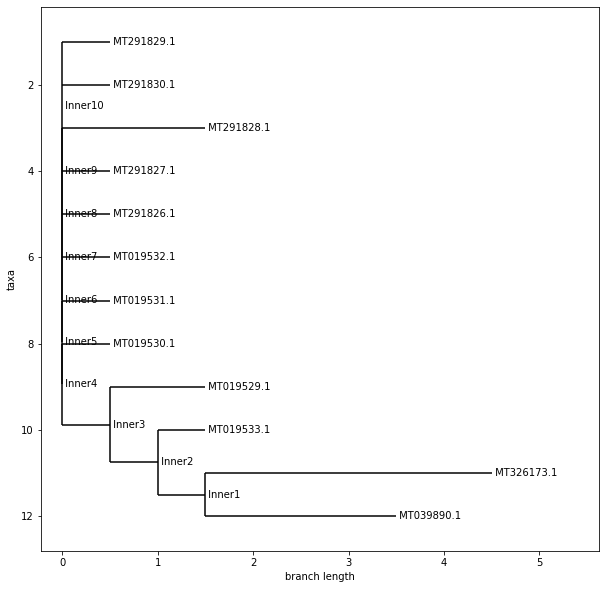

In [136]:
import matplotlib.pylab as plt

#Construct the NJ tree
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)

%matplotlib inline

tree.ladderize()   # Flip branches so deeper clades are displayed at top
fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)

### UPGA Tree
I next also wanted to compare the results of using the same data set to construct a UPGMA tree, again using biopython

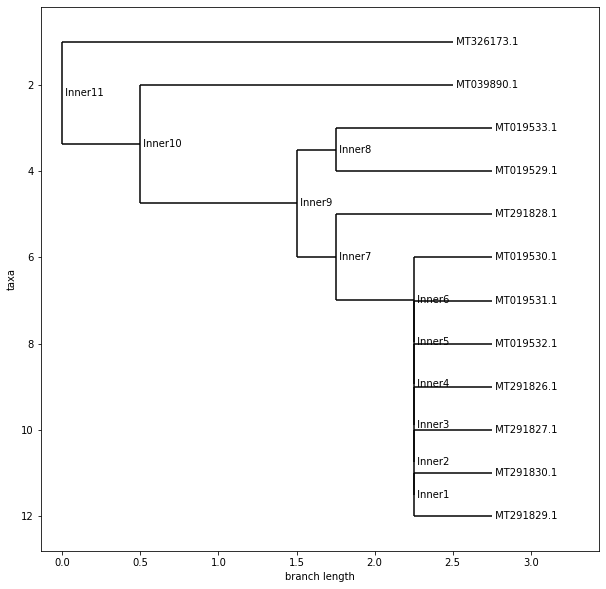

In [137]:
#Construct the UPGMA tree
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

%matplotlib inline

tree.ladderize()   # Flip branches so deeper clades are displayed at top
fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot(1, 1, 1)
Phylo.draw(tree, axes=axes)

Both trees are quite similar in their result. As I had expected, it appears that China, specifically Wuhan, is the source of SARS-Cov-2. It also seems to appear that Wuhan is also the source of the transmission of Sars-Cov-2 to the USA as well.